# Week#8 Ganesh Kale

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [11]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

import thinkstats2
import thinkplot

In [17]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [18]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [20]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

## Exercises 9.1

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [14]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [15]:
# Function to run different tests in the data 

# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length



def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)
    
    # difference in mean birth weight
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation - Preg length and total weight at birth
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t\t%0.2f\t\t%0.2f\t\t%0.2f\t\t%0.2f' % (n, p1, p2, p3, p4))


In [21]:
# test different test as mentioned below on different reduced sample size

# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length

n = len(live)
print(f"{'#Sample':^8}{'test1 p-value':^15}{'test2 p-value':^15}{'test3 p-value':^15}{'test4 p-value':^15}")
for _ in range(7):
    sample = live.sample(n)
    RunTests(sample)
    n //= 2

#Sample  test1 p-value  test2 p-value  test3 p-value  test4 p-value 
9148		0.17		0.00		0.00		0.00
4574		0.11		0.01		0.00		0.00
2287		0.50		0.02		0.01		0.00
1143		0.59		0.34		0.06		0.01
571		0.17		0.06		0.00		0.20
285		0.65		0.37		0.46		0.09
142		0.70		0.40		0.15		0.00


#### What happens to the p-values of these tests as sample size decreases? 
#### What is the smallest sample size that yields a positive test?

As mentioned in the exercise as sample size increases the power of hypothesis test incrases 
and test is more likely to be positive and vice versa.

But based on above test results as the sample size decreases we do not see the test is becoming negative, 
with smaller sample size for some tests the result is positive.



# Exercise 10.1

#### functions required for this exercise 

In [5]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope


def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys


def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res


def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)
        

def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
    
    
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)


def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample



Exercise: Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights

In [4]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [10]:
inter, slope = LeastSquares(heights,log_weights)
print(f" The intercept: {round(inter,4)} and slope :{round(slope,4)}")

 The intercept: 0.9931 and slope :0.0053


Make a scatter plot of the data and show the fitted line.

Text(0, 0.5, 'log10 weight (kg)')

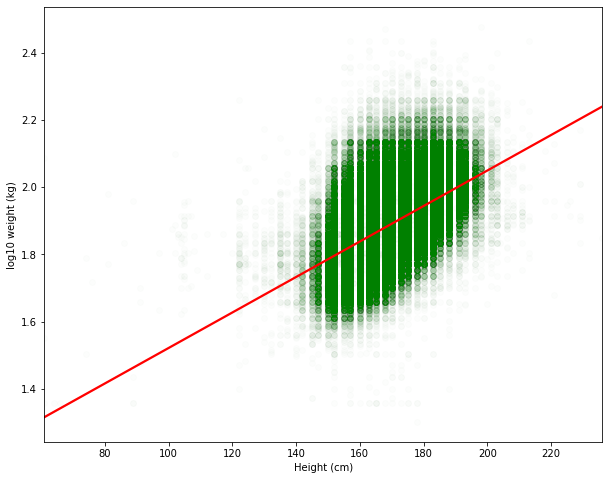

In [40]:
plt.figure(figsize=(10,8))
sns.regplot(x = heights,y= log_weights, color='g',scatter_kws={'alpha':0.01},line_kws={'color':'red'})
plt.xlabel('Height (cm)')
plt.ylabel('log10 weight (kg)')

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

Text(0, 0.5, 'Weight (kg)')

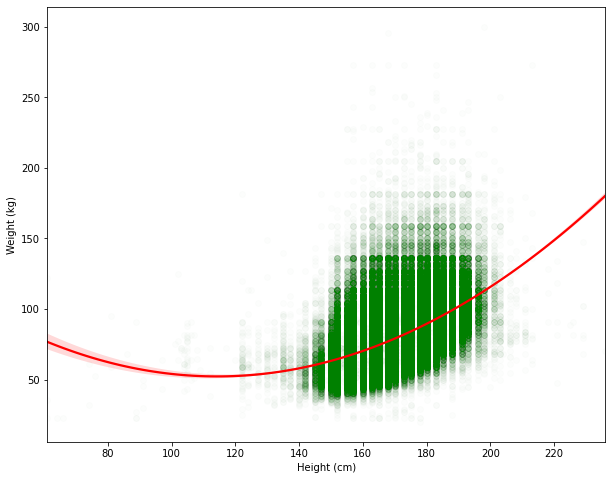

In [41]:
plt.figure(figsize=(10,8))
sns.regplot(x = heights,y= weights, color='g',order=2,scatter_kws={'alpha':0.01},line_kws={'color':'red'})
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')

Plot percentiles of the residuals.

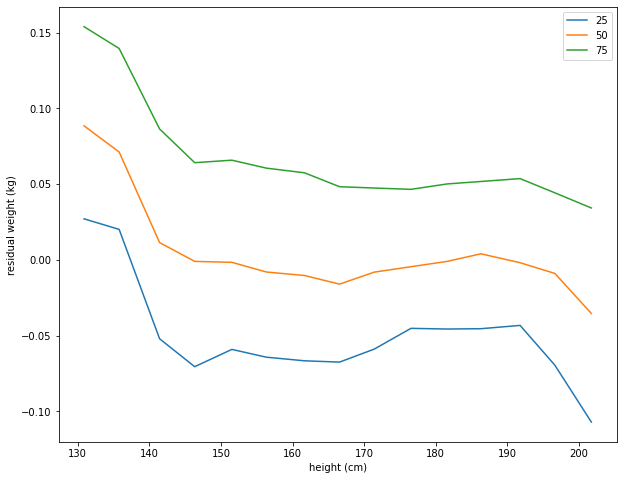

In [45]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

plt.figure(figsize = (10,8))
plt.xlabel('height (cm)')
plt.ylabel('residual weight (kg)')
for percent in [25, 50 , 75]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    sns.lineplot(x = means, y = ys, label = percent) 

Compute correlation.

In [50]:
cor = thinkstats2.Corr(heights, log_weights)
print(f"The correlation is: {cor}")

The correlation is: 0.5317282605983575


Compute coefficient of determination.

In [51]:
r2 = thinkstats2.CoefDetermination(log_weights, res)
print(f"The correlation is: {r2}")

The correlation is: 0.28273494311893366


Confirm that $R^2 = \rho^2$.

In [93]:
# cor**2 which same as r2 or difference is close to zero
cor**2, cor**2 - r2

(0.2827349431189548, 2.1149748619109232e-14)

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [53]:
std_ys = thinkstats2.Std(log_weights)
print(f"The Std(ys is: {std_ys}")

The Std(ys is: 0.10320725030004863


Compute Std(res), the RMSE of predictions that do use height.

In [60]:
std_res = thinkstats2.Std(res)
print(f"The Std(ys) is: {std_res}")

The Std(ys) is: 0.087407770804161


How much does height information reduce RMSE?

In [61]:
red_rmse = 1 - std_res / std_ys
print(f"Height information reduce RMSE is: {red_rmse}")

Theight information reduce RMSE is: 0.15308497658793052


Use resampling to compute sampling distributions for inter and slope.

In [63]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

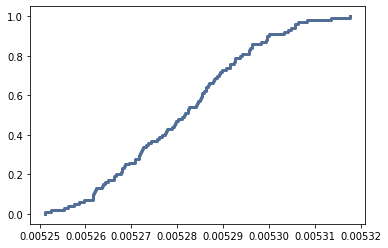

In [64]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [82]:
p_value = thinkstats2.Cdf(slopes)[0]
print(f"The p-value of the slope is: {p_value}")

The p-value of the slope is: 0


Compute the 90% confidence interval of slope.

In [83]:
ci = cdf.Percentile(5), cdf.Percentile(95)
print(f"The 90% CI range of slope is: {ci}")

The 90% CI of slope is: (0.005257447768065894, 0.00530558773758644)


Compute the mean of the sampling distribution.

In [84]:
mean = thinkstats2.Mean(slopes)
print(f"The mean of sampling distribution is: {mean}")

The mean of sampling distribution is: 0.005281042300966559


Compute the standard deviation of the sampling distribution, which is the standard error.

In [85]:
stderr = thinkstats2.Std(slopes)
print(f"The standard error of sampling distribution is: {stderr}")

The standard error of sampling distribution is: 1.4669935678536843e-05


Resample rows without weights, compute mean height, and summarize results.

In [86]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.9553936518523 0.01575134383487475 (168.92480900988298, 168.97970098425594)


Resample rows with weights. Note that the weight column in this dataset is called finalwt.

In [88]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.500536262859 0.016187314289585326 (170.47185169465834, 170.5311950524465)


## END